In [1]:
# -*- coding: utf-8 -*-:
import time

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [4]:
from pcs import tx
from pcs import helper as hlp
from pcs import utils
from pcs import autoencoder as ae

# Parameters

In [5]:
# Channel Parameters
chParam = utils.AttrDict()
chParam.M = 8
chParam.SNR_db = 5

# Auto-Encoder Parameters
aeParam = utils.AttrDict()
aeParam.nLayersEnc  = 1
aeParam.nLayersDec  = 5
aeParam.nFeaturesEnc  = 128
aeParam.nFeaturesDec  = 128

# Training Parameters
trainingParam = utils.AttrDict()
trainingParam.nBatches      = 16
trainingParam.batchSize     = 128*chParam.M
trainingParam.learningRate  = 0.01
trainingParam.iterations    = 31
trainingParam.displayStep   = 5

In [6]:
enc_inp = torch.tensor([[1]], dtype=torch.float)
# AWGN Capacity
AWGN_Cap = 0.5 * np.log2(1 + hlp.dB2lin(chParam.SNR_db, 'dB'))

# Experiments

In [5]:
def p_norm(p, x, fun=lambda x: torch.pow(torch.abs(x), 2)):
    return torch.sum(p * fun(x))

In [6]:
indices = np.random.choice(chParam.M,1)
onehot = F.one_hot(torch.tensor(indices, dtype=torch.int64), chParam.M)
P_M = torch.tensor(np.ones(chParam.M)*1/chParam.M)
norm_constellation = np.array([[-1.6953, -1.4693, -1.2432, -1.0172, -0.7912, -0.5651, -0.3391, -0.1130,
         0.1130,  0.3391,  0.5651,  0.7912,  1.0172,  1.2432,  1.4693,  1.6953]]).transpose()
x = np.matmul(onehot, torch.tensor(norm_constellation))

In [7]:
noise = torch.randn(1).reshape(-1, 1)
sigma2 = torch.tensor(1) / hlp.dB2lin(chParam.SNR_db, 'dB')  # 1 corresponds to the Power
noise = torch.sqrt(sigma2) * noise
y = torch.add(x, noise)

In [8]:
N0 = torch.mean(torch.square(torch.abs(x - y)))

qY = []

qYonX = (1 / torch.sqrt(torch.tensor(2) * torch.pi * N0)) * torch.exp( -torch.square(y - x) / (torch.tensor(2) * N0))

for ii in np.arange(chParam.M):
    temp = P_M[ii] * (1 / torch.sqrt(torch.tensor(2) * torch.pi * N0)) * torch.exp(-torch.square( y - norm_constellation[ii]) / (torch.tensor(2) * N0 ))
    qY.append(temp)

qY = torch.sum(torch.cat(qY, dim=0), dim=0)

qXonY = P_M[indices] * qYonX / qY

HX = -p_norm(P_M, P_M, lambda x: torch.log2(x))

MI = HX - torch.mean(-torch.log2(qXonY))


In [254]:
constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
constellation_t = torch.tensor(constellation, dtype=torch.float)
norm_factor = torch.rsqrt(utils.p_norm(P_M, constellation_t))
norm_constellation = torch.mul(constellation_t, norm_factor)
x = torch.matmul(F.one_hot(torch.arange(chParam.M), chParam.M).type(torch.FloatTensor), norm_constellation)

print(x)

tensor([-1.4949, -1.0678, -0.6407, -0.2136,  0.2136,  0.6407,  1.0678,  1.4949],
       grad_fn=<MvBackward0>)


# Implementation

In [7]:
def sampler(P_M, B):
    samples = torch.empty(0)
    for idx, p in enumerate(P_M):
        occurrences = torch.round(B * p).type(torch.LongTensor)
        samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]

In [8]:
def calculate_py_given_x(z, sig2):
     return (1 / (torch.sqrt(2 * torch.pi * sig2))) * torch.exp(-torch.square(z) / (sig2 * torch.tensor(2)))

In [9]:
def calculate_px_given_y(x, y, sigma2, chi):
    py = 0
    for i in chi:
        py += 0.25 * calculate_py_given_x(i, y, sigma2)
    pxy = 0.25 * calculate_py_given_x(x, y, sigma2) / py
    return pxy

In [10]:
def generate_AWGN(x_shape, SNR_db):
    noise = torch.randn(x_shape)
    sigma2 = torch.tensor(1) / hlp.dB2lin(SNR_db, 'dB')  # 1 corresponds to the Power
    noise = torch.sqrt(sigma2) * noise
    noise_power = torch.mean(torch.square(torch.abs(noise)))
    return noise, sigma2, noise_power

In [11]:
def plot_PDF( ask, pmf, db):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(ask, pmf)
    ax.set_title(f'SNR = {db} dB')
    ax.grid()
    fig.show()

In [20]:
# Initialize network
# encoder = ae.Encoder_Aref(in_features=1, width=aeParam.nFeaturesEnc, out_features=chParam.M)
# encoder = ae.Encoder_Aref_single_layer(in_features=1, out_features=chParam.M, bias=False)
encoder = ae.Encoder_Aref_tanh(in_features=1, width=chParam.M, out_features=chParam.M)
decoder = ae.Decoder_Aref(in_features=1, width=aeParam.nFeaturesDec, out_features=chParam.M)
CEloss = nn.CrossEntropyLoss()

In [21]:
# Optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=trainingParam.learningRate)

tensor(1., grad_fn=<SumBackward0>)


C:\Users\David\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\David\AppData\Local\Temp/ipykernel_17808/4269678781.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


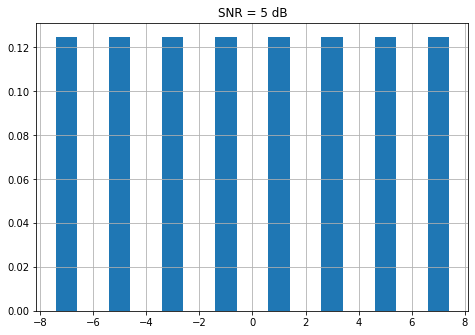

In [22]:
p_s_t = F.softmax(encoder(enc_inp), dim=1)
p_s = p_s_t.detach().numpy()[0]
constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
plot_PDF(constellation, p_s, chParam.SNR_db)
print(torch.sum(p_s_t))

In [23]:
def sampler(P_M, B):
    samples = torch.empty(0)
    for idx, p in enumerate(P_M):
        occurrences = torch.round(B * p).type(torch.LongTensor)
        if(occurrences >= 1):
            samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
        else:
            print(f"Error, idx: {idx}, p: {p}, B * p : {B * p}, ocurrences: {occurrences}")
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]



def loss_correction_factor(dec, zhat, sig2): # Initial loss function. "Worked" together with the complex encoder
     q = torch.amax(dec, 1)  # Q(c_i|Y_n) <-- learned
     p = calculate_py_given_x(zhat, sig2) # P(Y_n|c_i)
     return torch.sum(p * torch.log(q))

def loss_correction_factor_2(dec, zhat, sig2): #first attempt to get M different factors. But the P(Y_n|c_i) is not correct
     q = torch.transpose(dec, 0, 1) # Q(c_i|Y_n) <-- learned, dec is (1025, 16)
     p = calculate_py_given_x(zhat, sig2) # P(Y_n|c_i)
     factor = torch.sum(p * torch.log(q), dim=1)
     return torch.reshape(factor, (-1, 1))

def loss_correction_factor_3(dec): # Just averaging over the Yn the output probabilities. Loosing the information of which one is correct
    factor = torch.mean(torch.log(dec), dim=0)
    return torch.reshape(factor, (-1, 1))

def loss_correction_factor_4(dec, z_all, sig2): # right implementation if we want to use the AWGN P(Y_n|c_i) and obtain M factors.
     p = calculate_py_given_x(z_all, sig2) # P(Y_n|c_i)
     factor = torch.sum(torch.mul(p,torch.log(dec)), dim=0)  # dec =  Q(c_i|Y_n)
     return torch.reshape(factor, (-1, 1))

def loss_correction_factor_5(dec): # like 1 but without using P(Y_n|c_i). Averaging the M values
    q = torch.amax(dec, 1)
    factor = torch.mean(torch.log(q), dim=0)
    return factor

# Training loop
for j in range(trainingParam.iterations):
    for i in range(trainingParam.nBatches):
        # first generate the distribution
        l_M = encoder(enc_inp)
        P_M = F.softmax(l_M, dim=1)
        d_H = torch.reshape(-torch.log(P_M * torch.e), (-1, 1))
        # d_H = torch.mean(-torch.log(P_M * torch.e))


        # Sample indexes
        indices = sampler(torch.squeeze(P_M), trainingParam.batchSize).type(torch.LongTensor)  # labels
        # get onehot from sampled indices
        onehot = F.one_hot(indices, chParam.M)


        # normalization & Modulation
        constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
        constellation_t = torch.tensor(constellation, dtype=torch.float)
        norm_factor = torch.rsqrt(utils.p_norm(P_M, constellation_t))
        norm_constellation = torch.mul(constellation_t, norm_factor)
        x = torch.matmul(onehot.type(torch.FloatTensor), norm_constellation)
        x_all = torch.matmul(F.one_hot(torch.arange(chParam.M), chParam.M).type(torch.FloatTensor), norm_constellation)
        should_always_be_one = utils.p_norm(P_M, norm_constellation)

        # Channel
        noise_snr, sigma2, noise_power = generate_AWGN(x.shape, chParam.SNR_db)
        y = torch.add(x, noise_snr)
        y_power = utils.p_norm(P_M, torch.add(norm_constellation, generate_AWGN(norm_constellation.shape, chParam.SNR_db)[0] ))

        # demodulator
        y_vec = torch.reshape(y, (-1, 1))
        dec = decoder(y_vec)


        # loss
        #zhat = torch.sub(y, x)
        z_all = torch.abs(y.reshape(-1,1) - x_all.reshape(1, -1))
        loss = CEloss(dec, onehot.type(torch.float))
        #factor = loss_correction_factor(F.softmax(dec, 1), zhat, sigma2)
        # factor = loss_correction_factor_2(F.softmax(dec, 1), zhat, sigma2)
        factor = loss_correction_factor_3(F.softmax(dec, 1))
        # factor = loss_correction_factor_4(F.softmax(dec, 1), z_all, sigma2)
        # factor = loss_correction_factor_5(F.softmax(dec, 1))

        optimizer.zero_grad()
        loss.backward()

        # for param in encoder.parameters():
        #     print(type(param.data), param.size())
        #     print(param.data)

        # for w in encoder.parameters():
        #     w.grad += (d_H + factor)


        for name, param in encoder.named_parameters():
            if 'weight' in name:
                param.grad += d_H #change the sign
                param.grad += factor

        optimizer.step()

        MI = utils.gaussianMI_ASK_Non_Uniform(indices, x, y, norm_constellation, chParam.M, P_M, dtype=torch.double).detach().numpy()

    # Printout and visualization
    if j % int(trainingParam.displayStep) == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f} - always 1: {should_always_be_one :.2} - MI: {MI :.4f} - Cap.: {AWGN_Cap:.4f}')


epoch 0: Loss = 1.8994 - always 1: 1.0 - MI: 0.9869 - Cap.: 1.0287
Error, idx: 1, p: 0.00044580840039998293, B * p : 0.4565078020095825, ocurrences: 0
Error, idx: 6, p: 0.00044580840039998293, B * p : 0.4565078020095825, ocurrences: 0
Error, idx: 0, p: 0.0004142539401073009, B * p : 0.4241960346698761, ocurrences: 0
Error, idx: 1, p: 0.0003707260184455663, B * p : 0.3796234428882599, ocurrences: 0
Error, idx: 6, p: 0.0003707260184455663, B * p : 0.3796234428882599, ocurrences: 0
Error, idx: 7, p: 0.0004142539401073009, B * p : 0.4241960346698761, ocurrences: 0
Error, idx: 0, p: 0.0003489780065137893, B * p : 0.35735347867012024, ocurrences: 0
Error, idx: 1, p: 0.00031041353940963745, B * p : 0.31786346435546875, ocurrences: 0
Error, idx: 6, p: 0.00031041353940963745, B * p : 0.31786346435546875, ocurrences: 0
Error, idx: 7, p: 0.0003489780065137893, B * p : 0.35735347867012024, ocurrences: 0
Error, idx: 0, p: 0.00029633569647558033, B * p : 0.30344775319099426, ocurrences: 0
Error, idx

KeyboardInterrupt: 

In [22]:
 for param in encoder.parameters():
            print(type(param.data), param.size())
            print(param.data)

<class 'torch.Tensor'> torch.Size([8, 1])
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]])
<class 'torch.Tensor'> torch.Size([8])
tensor([nan, nan, nan, nan, nan, nan, nan, nan])
<class 'torch.Tensor'> torch.Size([8, 8])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan]])
<class 'torch.Tensor'> torch.Size([8])
tensor([nan, nan, nan, nan, nan, nan, nan, nan])
<class 'torch.Tensor'> torch.Size([8, 8])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, na

Power should always be one: tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)


C:\Users\David\AppData\Local\Temp/ipykernel_13452/4269678781.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


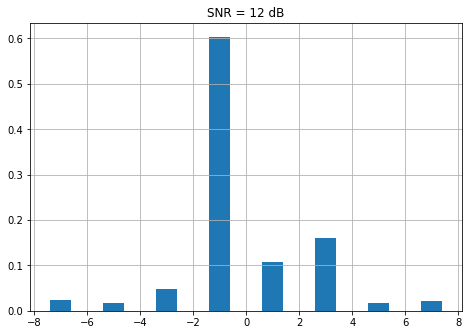

In [15]:
# Data for the plots
p_s_t = F.softmax(encoder(enc_inp), dim=1)
p_s = p_s_t.detach().numpy()[0]
constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
constellation_t = torch.tensor(constellation, dtype=torch.float64)
norm_factor = torch.rsqrt(utils.p_norm(p_s_t, constellation_t))
norm_constellation = norm_factor * constellation_t
print('Power should always be one:', utils.p_norm(p_s_t, norm_constellation))
plot_PDF(constellation, p_s, chParam.SNR_db)